In this notebook, I will build upon the random tree model and create ensemble machine learning models. Specifically, *Bagging* and *Random Forests*. The target metric is *Root Mean Squared Error* (RMSE). I also include other metrics such as *Mean Absolute Percentage Error*.

Gradient Boosting and XGBoost will be featured in their own notebook

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor # bagging model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

import matplotlib.pyplot as plt

In [2]:
# Set pandas display precision to 4 decimal places
pd.options.display.float_format = '{:.4f}'.format
np.set_printoptions(precision=4)

In [3]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Importing Dataset

In [4]:
# Importing processed dataframe
path_project = "C:/Users/Conno/Documents/Career/Projects/Hospital_Charges/tree_based_models"

os.chdir(path_project)
plots_dir = 'bagging_and_rf_plots' # stores plots in plot folder

df = pd.read_csv("../df_processed.csv")

# do this later in data_cleaning file
bool_cols = df.select_dtypes(include=['bool']).columns
df[bool_cols] = df[bool_cols].astype(int)

df.dtypes

age                           float64
death                           int64
hospdead                        int64
slos                            int64
d_time                          int64
num_co                          int64
edu                           float64
scoma                         float64
charges                       float64
avtisst                       float64
sps                           float64
aps                           float64
surv2m                        float64
surv6m                        float64
hday                            int64
diabetes                        int64
dementia                        int64
prg2m                         float64
prg6m                         float64
dnrday                        float64
meanbp                        float64
wblc                          float64
hrt                           float64
resp                          float64
temp                          float64
crea                          float64
sod         

## Train-Test Split

In [5]:
X = df.drop(columns = ["charges"])
y = df["charges"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 32)

# Bagging

Since *Decision Trees* suffer from high variance, Bootstrap Aggregation *Bagging* is a general-purpose procedure for reducing the variance of a statistical learning method which helps overfitting. It is particularly useful and frequently used in the context of decision trees.

Basically, we create a bunch of bootstrapped datasets from the training set and a decision tree is trained on each bootstrapped dataset. We then take the average of the predictions from each decision tree:

$$\hat{f}_{bag}(x) = \frac{1}{B}\sum_{b=1}^{B}\hat{f}^{*b}(x)$$

Where $\hat{f}^{*b}$ is a particular prediction from one decision tree

We will also tune the hyperparameters based on 5-fold cross-validation

In [6]:
bagging_model = BaggingRegressor(estimator = DecisionTreeRegressor(), random_state = 32)

In [7]:
# parameter grid for cross-validation
param_grid_bag ={
    'n_estimators': [10, 50, 500, 1000] #n-trees
}

grid_search_bag = GridSearchCV(
                    estimator = bagging_model,
                    param_grid = param_grid_bag,
                    cv = 5,
                    scoring = 'neg_mean_squared_error',
                    n_jobs = -1 # parallel processing
            )

grid_search_bag.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=BaggingRegressor(estimator=DecisionTreeRegressor(),
                                        random_state=32),
             n_jobs=-1, param_grid={'n_estimators': [10, 50, 500, 1000]},
             scoring='neg_mean_squared_error')

In [66]:
print("Best Parameters from Grid Search: ", grid_search_bag.best_params_)
print("Best Cross-Validation Score from Grid Search: ", -grid_search_bag.best_score_)


Best Parameters from Grid Search:  {'n_estimators': 1000}
Best Cross-Validation Score from Grid Search:  3400571696.1191206


## Plotting

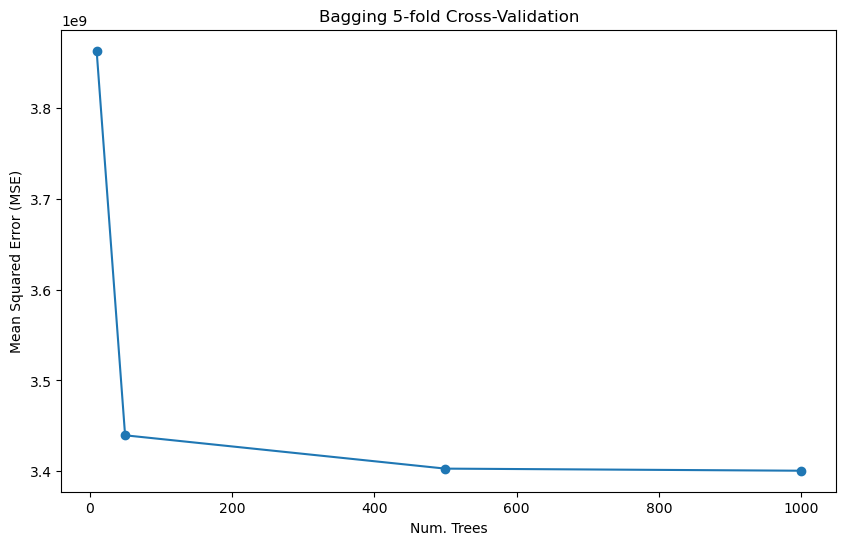

In [78]:
results_bag = grid_search_bag.cv_results_

# retrieves n_trees and their corresponding mean cv results
n_estimators = results_bag['param_n_estimators'].data
mean_test_scores = -results_bag['mean_test_score']

plt.figure(figsize=(10,6))
plt.plot(n_estimators, mean_test_scores, marker = 'o')
plt.xlabel("Num. Trees")
plt.ylabel('Mean Squared Error (MSE)')
plt.title('Bagging 5-fold Cross-Validation')

bag_cv_path = os.path.join(plots_dir, 'bag_cv_plot')
plt.savefig(bag_cv_path)
plt.show()

We can see here that increasing the number of trees starting to produce diminishing returns. 1000 was expectedly the best but 50 trees already showcased good performance.

## Feature Importance

In [9]:
bag_best = grid_search_bag.best_estimator_

bag_fi = np.mean([
    tree.feature_importances_ for tree in bag_best.estimators_
], axis = 0)

bag_fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': bag_fi
}).sort_values(by = 'Importance', ascending = False)

bag_fi_df

,Feature,Importance
3,slos,0.3461
13,hday,0.1948
18,dnrday,0.0813
8,avtisst,0.0735
0,age,0.0291
20,wblc,0.0273
7,scoma,0.0214
10,aps,0.0211
6,edu,0.0185
22,resp,0.0160


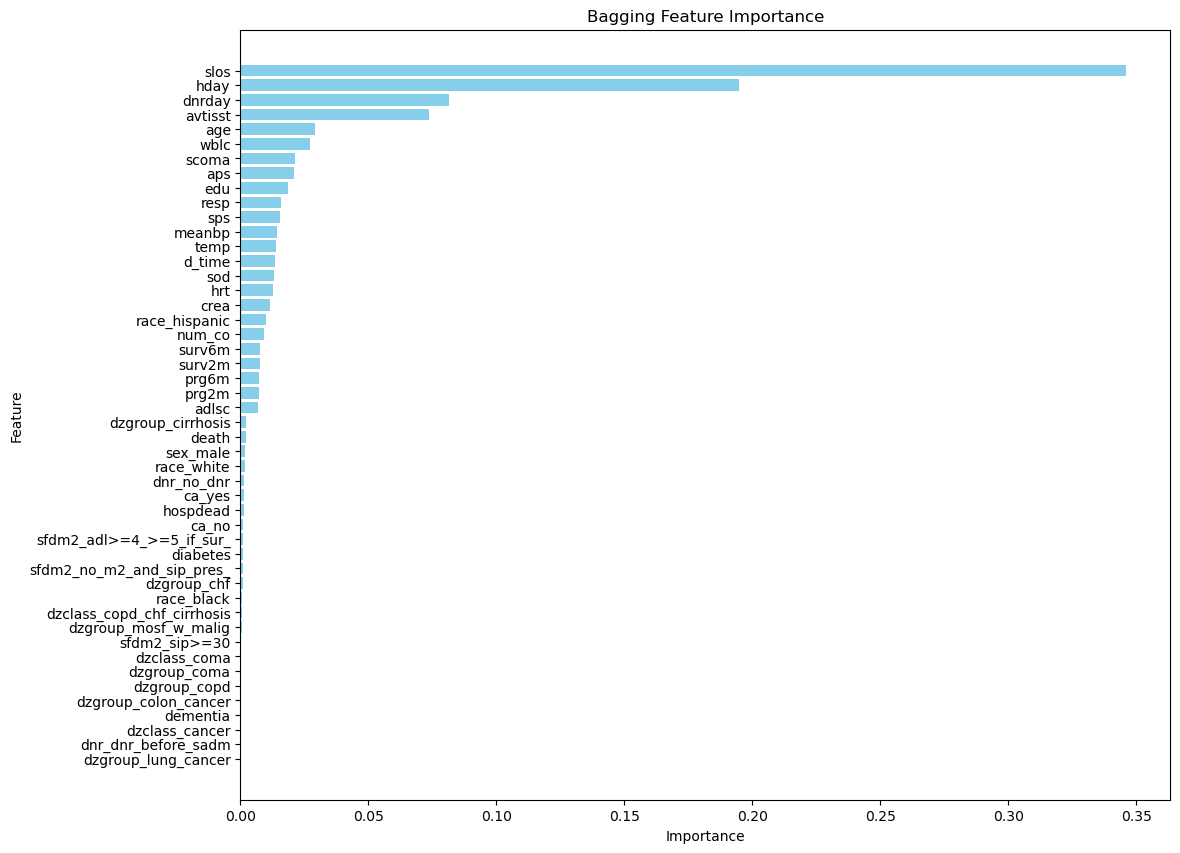

In [11]:
plt.figure(figsize = (12, 10))
plt.barh(bag_fi_df["Feature"], bag_fi_df["Importance"], color = 'skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Bagging Feature Importance')
plt.gca().invert_yaxis()

bag_fi_path = os.path.join(plots_dir, 'bag_fi_plot')
plt.savefig(bag_fi_path)

plt.show()

## Predicting Test Set

In [12]:
bag_best = grid_search_bag.best_estimator_

y_pred_bag = bag_best.predict(X_test)

bag_mape = mean_absolute_percentage_error(y_test, y_pred_bag)
bag_mae = mean_absolute_error(y_test, y_pred_bag)
bag_mse = mean_squared_error(y_test, y_pred_bag)
bag_rmse = rmse(y_test, y_pred_bag)

print("Bagging MAPE:", round(bag_mape, 4))
print("Bagging MAE:", round(bag_mae, 4))
print("Bagging MSE:", round(bag_mse, 4))
print("Bagging RMSE:", round(bag_rmse, 4))

Bagging MAPE: 0.4525
Bagging MAE: 23128.0004
Bagging MSE: 3560662437.5799
Bagging RMSE: 59671.2865


Bagging produced better results than the linear regression models. We can see that we are achieving a pretty good *Mean Absolute Error* but the RMSE is still high due to the influences of outliers

# Random Forests

Random Forests provide an improvement over bagged trees by way of a small tweak that *decorrelates* the trees. This reduces the **variance** when we average the trees. As in bagging, we build a number of decision teres on the bootstrapped training samples. When building these decision trees, each split in a tree is considered, a random select of $m$ predictors is chosen as split candidates from the full set of $p$ predictors. The split is allowed to use only one of those $m$ predictors.

The selection criteria of $m$ predictors is a hyperparameter for which we'll test $m = \sqrt{p}$ and $m = \log_{2}p$

Bagging is a special case of a random forest where $m = p$

Using a small value of $m$ in building a random forest will typically be helpful when we have a large number of correlated predictors. In our case, per the correlation matrix, we do have several variables that are highly correlated with each other. (The majority are still practically uncorrelated)

In [13]:
rf_model = RandomForestRegressor(random_state = 32)

In [14]:
# parameter grid for cross-validation
param_grid_rf ={
    'n_estimators': [10, 50, 500, 1000], #n-trees
    'max_features': ['sqrt', 'log2']
}

grid_search_rf = GridSearchCV(
                    estimator = rf_model,
                    param_grid = param_grid_rf,
                    cv = 5,
                    scoring = 'neg_mean_squared_error',
                    n_jobs = -1 # parallel processing
            )

grid_search_rf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=32), n_jobs=-1,
             param_grid={'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 50, 500, 1000]},
             scoring='neg_mean_squared_error')

In [15]:
print("Best Parameters from Grid Search: ", grid_search_rf.best_params_)
print("Best Cross-Validation Score from Grid Search: ", -grid_search_rf.best_score_)

Best Parameters from Grid Search:  {'max_features': 'sqrt', 'n_estimators': 1000}
Best Cross-Validation Score from Grid Search:  3439656593.180771


## Plotting

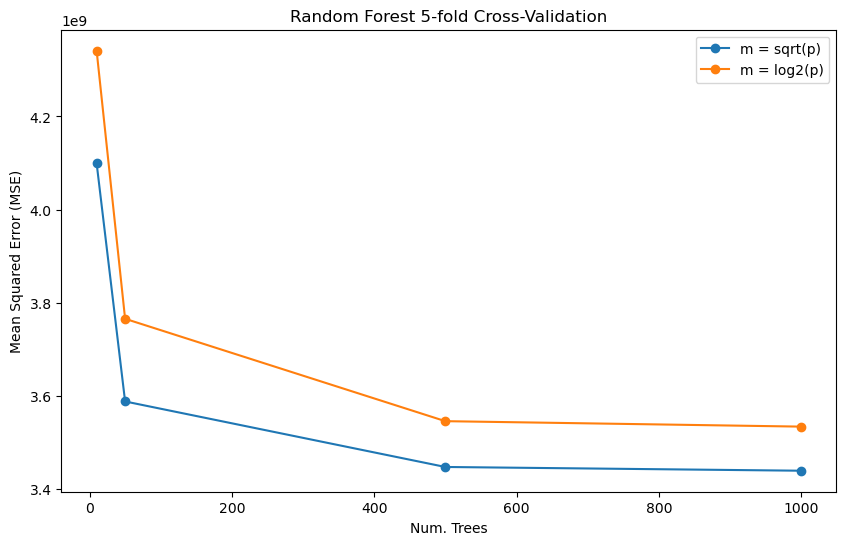

In [16]:
results_rf = grid_search_rf.cv_results_

results_rf_df = pd.DataFrame(results_rf)

# filtering for sqrt and log2
results_sqrt = results_rf_df[results_rf_df['param_max_features'] == 'sqrt']
results_log2 = results_rf_df[results_rf_df['param_max_features'] == 'log2']

# retrieving the sqrt scores for the corresponding num of trees
n_estimators_sqrt = results_sqrt['param_n_estimators'].astype(int)
mse_sqrt = -results_sqrt['mean_test_score']

# retrieving the sqrt scores for the corresponding num of trees
n_estimators_log2 = results_log2['param_n_estimators'].astype(int)
mse_log2 = -results_log2['mean_test_score']

plt.figure(figsize=(10,6))
plt.plot(n_estimators_sqrt, mse_sqrt, marker= 'o', label = "m = sqrt(p)")
plt.plot(n_estimators_log2, mse_log2, marker = 'o', label = "m = log2(p)")
plt.xlabel("Num. Trees")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Random Forest 5-fold Cross-Validation")
plt.legend()

rf_cv_path = os.path.join(plots_dir, 'rf_cv_plot')
plt.savefig(rf_cv_path)

plt.show()

## Feature Importance

In [17]:
rf_best = grid_search_rf.best_estimator_

rf_fi = rf_best.feature_importances_

rf_fi_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_fi
}).sort_values(by = 'Importance', ascending = False)

rf_fi_df

,Feature,Importance
3,slos,0.1583
18,dnrday,0.1432
13,hday,0.1223
8,avtisst,0.0850
9,sps,0.0376
10,aps,0.0351
0,age,0.0333
4,d_time,0.0301
11,surv2m,0.0254
7,scoma,0.0244


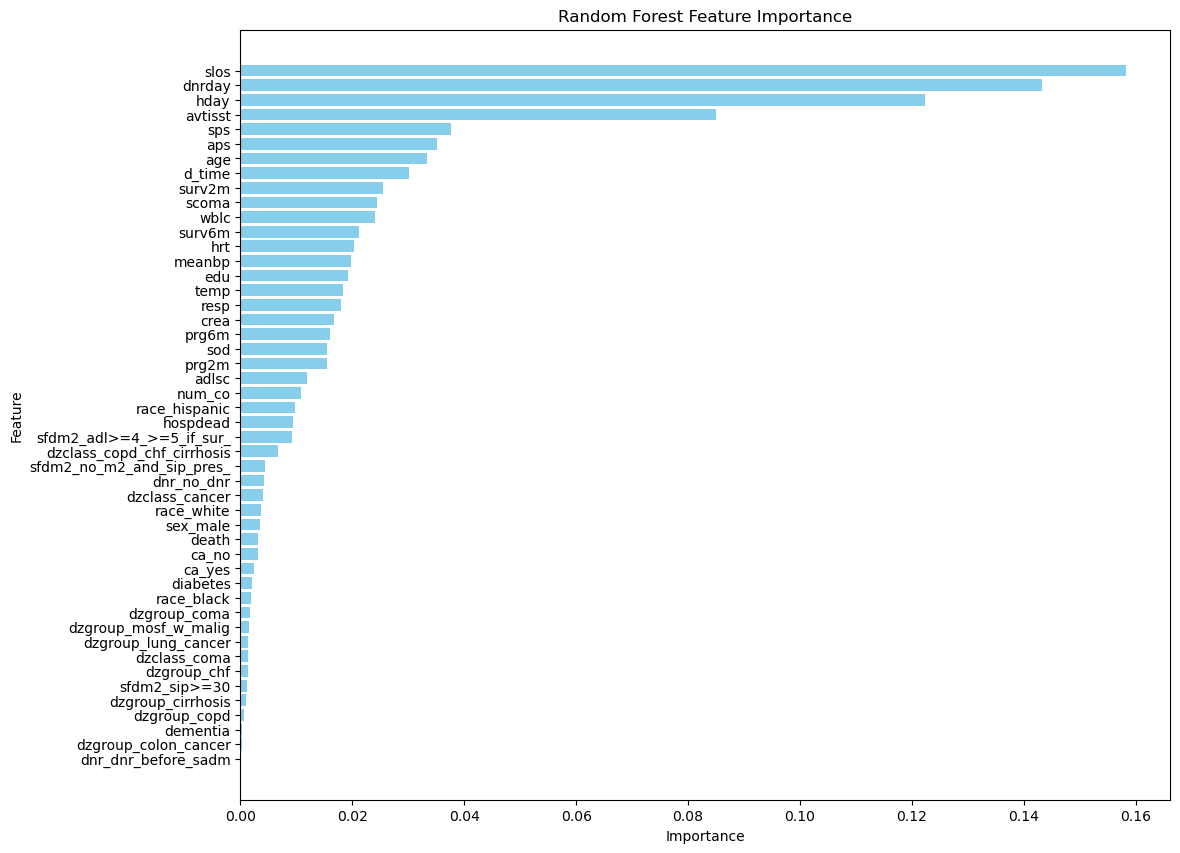

In [19]:
plt.figure(figsize = (12, 10))
plt.barh(rf_fi_df["Feature"], rf_fi_df["Importance"], color = 'skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Random Forest Feature Importance')
plt.gca().invert_yaxis()

rf_fi_path = os.path.join(plots_dir, 'rf_fi_plot')
plt.savefig(rf_fi_path)

plt.show()

## Predicting Test Set

In [20]:
y_pred_rf = rf_best.predict(X_test)

rf_mape = mean_absolute_percentage_error(y_test, y_pred_rf)
rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_mse = mean_squared_error(y_test, y_pred_rf)
rf_rmse = rmse(y_test, y_pred_rf)

print("Random Forest MAPE:", round(rf_mape, 4))
print("Random Forest MAE:", round(rf_mae, 4))
print("Random Forest MSE:", round(rf_mse, 4))
print("Random Forest RMSE:", round(rf_rmse, 4))

Random Forest MAPE: 0.6532
Random Forest MAE: 24414.1893
Random Forest MSE: 3831157503.4871
Random Forest RMSE: 61896.3448


Surprisingly, the *Random Forest Model* performed worse than the *Bagging* model. This is atypical since Random Forest builds upon Bagging but not unheard of. 